# Assignment 3

> Group Members: Alexandros Gilch, Paul Grass, Tim Mensinger, Philipp Schirmer, Julius Kappenberg

## Question I: Crises

In this notebook our group aims to answer the question whether financial crises can be predicted using past data. Again, the notebook is structured as follows: We first import all functions that are implemented in a seperate module. Then, in the results section we then answer questions *i. - iii*. Additionally to the logistic regression model we use neural networks and boosting techniques to see if a flexible model can achieve better performance. At last we list the code of the module.

Once more we remark that the code section may be skipped by everyone uninterested in the implementation, and that this notebook is best enjoyed [online](https://nbviewer.jupyter.org/github/timmens/macro_problems/blob/main/assignment3.ipynb?flush_cache=False).  

## Results

### i.

In [1]:
from auxiliary import *

df = read_and_clean_data()

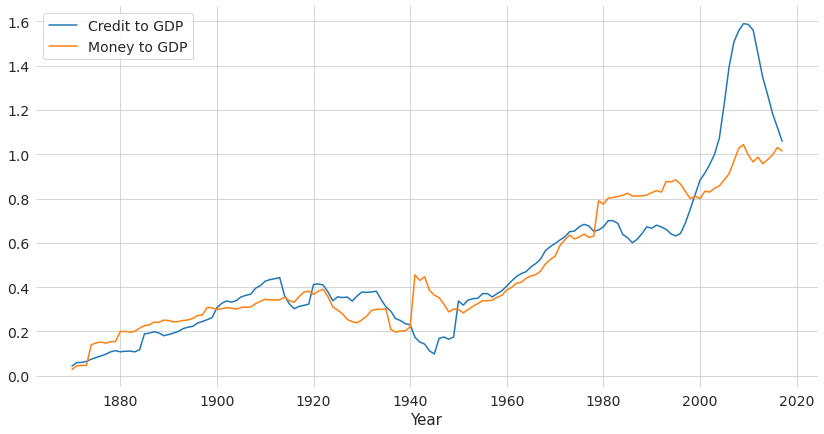

In [2]:
df_agg = compute_aggregate_credit_and_money(df)

plot_aggregate_credit_and_money(df_agg)

### ii.

Below we fit a logit fixed effects model with 5 lags of log changes in real credit as an additional predictor. To answer **ii.1**, the p-value of an f-test for joint significance of the five lags of real credit growth is given below as ~6.5e-7. That is we can reject the null hypothesis of no effect with great confidence. We then print the coefficient estimates, standard errors and standard pvalues (i.e. non corrected for multiple-testing problems) corresponding to the five lags of real credit growth. In particular we may note that the second lag is statistically highly significant.

In the table below that we print the fixed effect estimates. Since we include an intercept in the regression the fixed effects are relative to the country left out, which in our case is USA. The only country fixed effect with a reasonable p-value is Canada. However, due to a multiple testing problem we may have to rule this (statistical) signifance out too.

In [3]:
formula = "crisisJST ~ C(ifs) + " + create_formula_with_lags("diff_log_real_credit", 5)

y, X = create_model_data(formula, df)

model = fit_logit(y, X, backend="statsmodels")

In [4]:
f_test_pvalue, params, fixed_effects = extract_info_from_statsmodels_fit(model, df)

In [5]:
f_test_pvalue

6.51402668550305e-07

In [6]:
params

,coef,se,pvalue
Lag,,,
1,1.062679,1.246715,3.940014e-01
2,5.542023,1.089714,3.661618e-07
3,-0.241261,0.098925,1.473544e-02
4,0.305101,0.579162,5.983352e-01
5,0.701906,0.927231,4.490549e-01


In [7]:
fixed_effects

,coef,se,pvalue
country,,,
UK,-0.208926,0.684654,0.760248
Belgium,0.330508,0.649003,0.610574
Denmark,0.085535,0.619747,0.890228
France,-0.830577,0.865253,0.337093
Germany,-0.278321,0.667320,0.676626
Italy,0.327526,0.580155,0.572380
Netherlands,-0.841021,0.848713,0.321717
Norway,-0.351245,0.683981,0.607580
Sweden,0.155336,0.619436,0.801992


### iii.: Model Evaluation

#### iii.1 - iii.3

We start by plotting the ROC curves for the baseline specification and the additional variables in a 2x2 grid plot. The upper-left plot visualizes the baseline case. In the upper-right we add money, in the lower-left we add asset prices and in the lower-right we add current account as additional predictor variables. Each additonal variable is added with up to five lags. From the figure we see that the model including asset prices achieves the highest out-of-sample score (0.71).

In the figure below the grid plot we illustrate the case of using all regressors. Remarkably we achieve a much lower out-of-sample score than in the case of using only asset prices as additional predictors.


*Remark.* We actually do not fit a standard logistic regression model. To control the overfitting we apply an l1 regularization. We also compared our regularized models to the l2 regularized and unregularized models, and found that the l1 regularization achieves best results. This makes sense as we have seen in the previous part that most country fixed effects are insignificant.

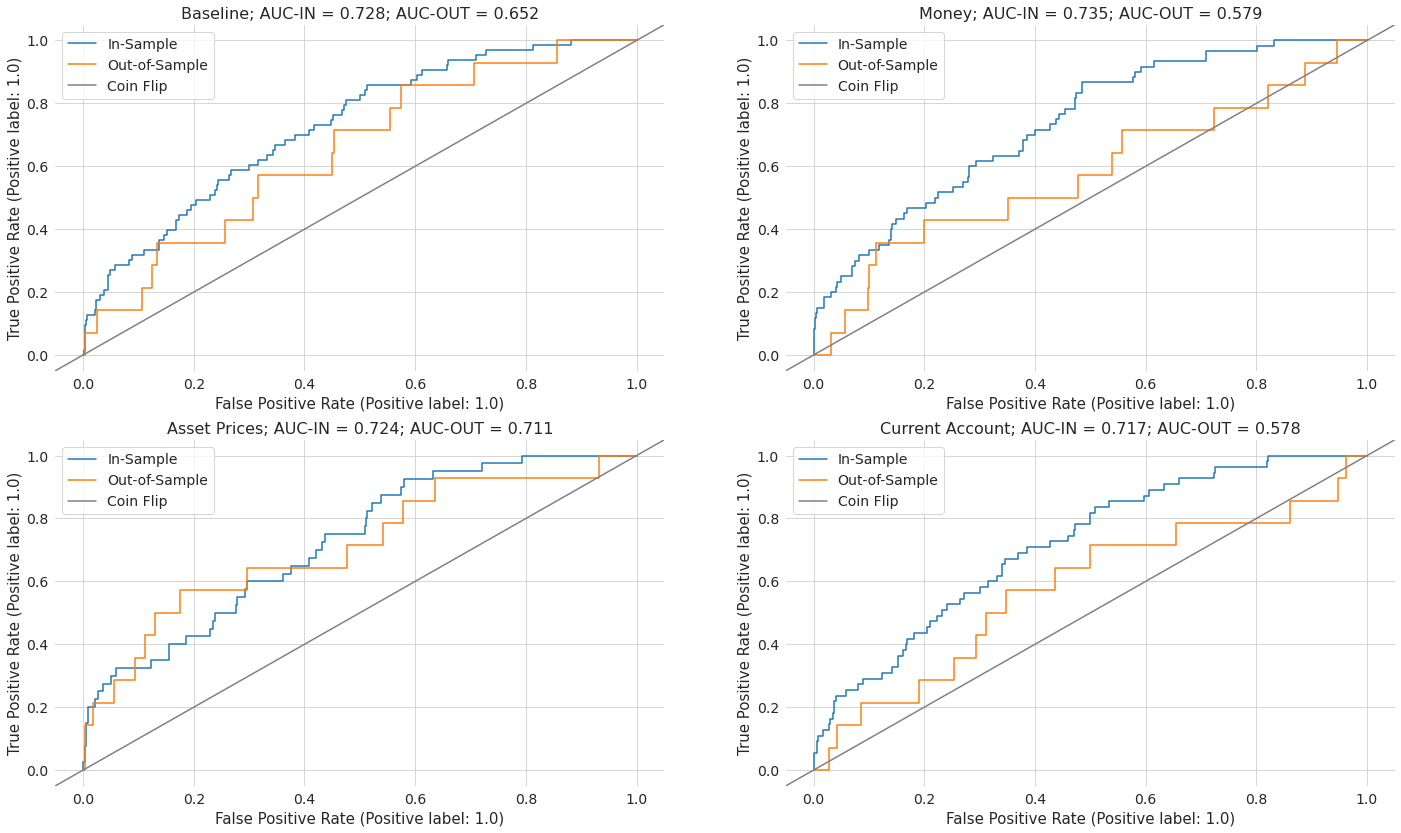

In [8]:
plot_predictor_comparison(
    fit_logit,
    df,
    formula,
    backend="sklearn",
    max_iter=10_000,
    penalty="l1",
    solver="liblinear",
)

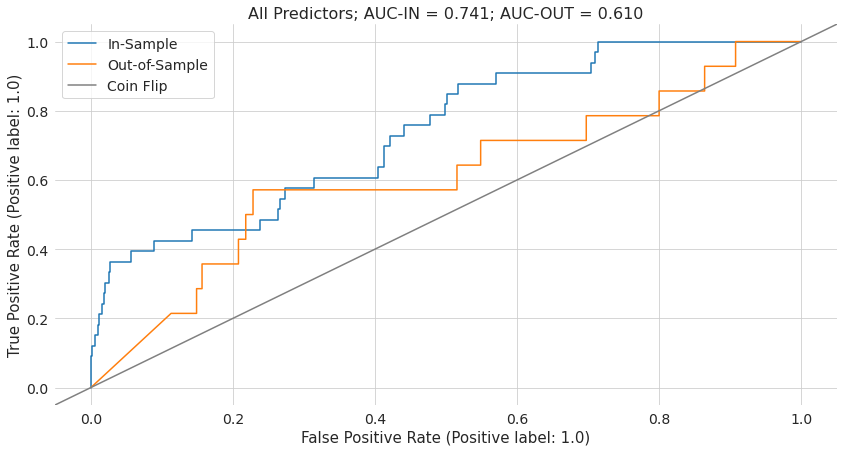

In [9]:
with_predictors = [
    f"{var}.shift({lag})" for var in ("money", "hpnom", "ca") for lag in range(1, 6)
]

data = create_test_train_data(df, formula, with_predictors=with_predictors)

model = fit_logit(
    data=data, backend="sklearn", max_iter=10_000, penalty="l1", solver="liblinear"
)
plot_roc_curve(model, **data, title="All Predictors")

## Neural Networks

A trivial extension to the above method is to use a more flexible classifier. In this section we focus on a neural network classifier with a "30-30-30-30" hidden layer architecture with ReLu activation function. As with the classical logistic regression, the model using 
only asset prices achieves the highest out-of-sample roc-auc score. The figure below considers only the comparison of one additional regressor. Interestingly enough the networks do not outperform the regularized logistic regression. This may be due to many reasons. Firstly and most likely, we will have dominant first order effects which are captured by the logistic regression. Secondly, the networks weights are not l1 regularized (I was too lazy to implement this). Using l1 regularized weights we could have improved the generalizability of the model.

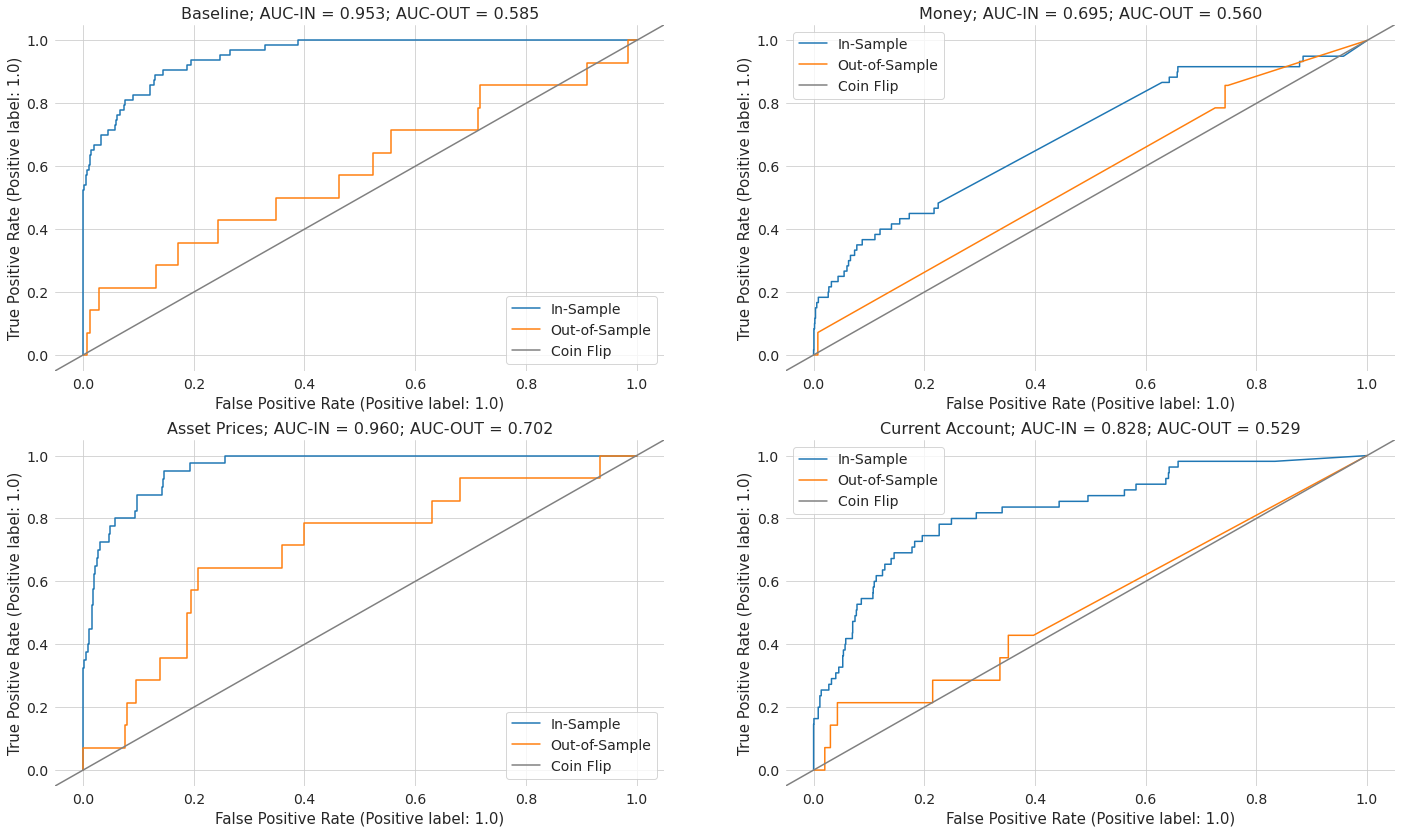

In [12]:
np.random.seed(1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_predictor_comparison(fit_neural_network, df, formula, layers="30-30-30-30")

## Gradient Boosting

At last we consider another popular model: gradient boosted trees. Since we have seen that the model with only asset prices performs best so far we will only concentrate on this case. We also see here that a out-of-sample score of 0.71 is achieved. Again without much hyper parameter tuning.

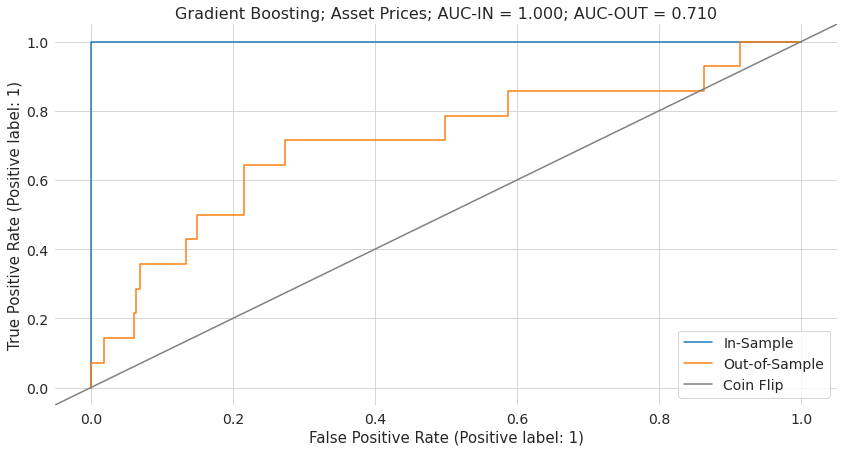

In [11]:
with_predictors = [f"hpnom.shift({l})" for l in range(1, 6)]
data = create_test_train_data(df, formula, with_predictors)
model = fit_catboost(data=data, loss_function="CrossEntropy")

fig, ax = plt.subplots()
fig.set_size_inches(14, 7)

plot_roc_curve(model, **data, title="Gradient Boosting; Asset Prices", ax=ax)

## Code

Below we print the contents of the auxiliary module. 


```Python
"""This module contains auxiliary code for the third assignment."""
import warnings  # noqa: F401

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
from catboost import CatBoostClassifier
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve as sklearn_plot_roc_curve
from sklearn.metrics import roc_auc_score
from statsmodels.discrete.discrete_model import Logit

sns.set_style("whitegrid")


def read_and_clean_data() -> pd.DataFrame:
    """Read data, set index and rename tloans to credit."""
    # read
    df = pd.read_stata("data/JSTdatasetR5.dta")

    # simple clean
    df = df.set_index(["ifs", "year"])
    df = df.rename(columns={"tloans": "credit"})

    # generate additional regressors
    for col in ["credit", "money", "hpnom"]:
        df = df.assign(**{f"real_{col}": df[col] / df.cpi})
        df = df.assign(**{f"diff_log_real_{col}": np.log(df[f"real_{col}"]).diff(1)})

    return df


def compute_aggregate_credit_and_money(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate credit and money for each year."""
    df_agg = df.groupby("year")[["credit", "money", "gdp"]].sum()
    df_agg = df_agg.assign(
        **{f"{var}2gdp": df_agg[var] / df_agg.gdp for var in ("credit", "money")}
    )
    df_agg = df_agg.reset_index()
    return df_agg


def plot_aggregate_credit_and_money(df_agg: pd.DataFrame) -> None:
    """Plot time-series of aggregate credit and money."""
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)

    sns.lineplot(x="year", y="credit2gdp", data=df_agg, ax=ax, label="Credit to GDP")
    sns.lineplot(x="year", y="money2gdp", data=df_agg, ax=ax, label="Money to GDP")

    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set(ylabel="", xlabel="Year")
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.legend(fontsize=14)
    return None


def create_formula_with_lags(var_name: str, n_lags: int) -> str:
    """Create formula str of var_name with n_lags."""
    covariates = [f"{var_name}.shift({i})" for i in range(1, n_lags + 1)]
    formula = " + ".join(covariates)
    return formula


def extract_info_from_statsmodels_fit(model, df):
    """Extract info from statsmoels fit."""
    # test for joint signifance
    select_relevant_params = model.params.index.str.startswith("diff_log_real_credit")
    r_matrix = np.eye(len(select_relevant_params))[
        -select_relevant_params.sum() :
    ]  # noqa E203
    f_test_pvalue = float(model.f_test(r_matrix).pvalue)

    # info on diff_log_real_credit estimates
    params = pd.DataFrame(
        {
            "coef": model.params[select_relevant_params],
            "se": model.bse[select_relevant_params],
            "pvalue": model.pvalues[select_relevant_params],
        }
    )
    params = params.set_axis(range(1, len(params) + 1))
    params = params.rename_axis("Lag")

    # info on fixed effect estimates
    ifs2country = (
        df.reset_index().groupby("ifs")["country"].first().to_frame().reset_index()
    )
    select_fixed_effects = model.params.index.str.startswith("C(ifs)")

    fixed_effects = pd.DataFrame(
        {
            "coef": model.params[select_fixed_effects],
            "se": model.bse[select_fixed_effects],
            "pvalue": model.pvalues[select_fixed_effects],
            "ifs": df.index.get_level_values("ifs").unique().sort_values()[1:],
        }
    )

    fixed_effects = fixed_effects.merge(ifs2country, on="ifs")
    fixed_effects = fixed_effects.drop("ifs", axis=1).set_index("country")

    return f_test_pvalue, params, fixed_effects


def plot_roc_curve(model, X_train, y_train, X_test, y_test, title=None, ax=None):
    """Plot ROC curve."""
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(14, 7)

    sklearn_plot_roc_curve(model, X_train, y_train, ax=ax, label="In-Sample")
    sklearn_plot_roc_curve(model, X_test, y_test, ax=ax, label="Out-of-Sample")
    ax.axline([0, 0], [1, 1], color="gray", label="Coin Flip")

    auc_in = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    auc_out = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    suffix = f"AUC-IN = {auc_in:.3f}; AUC-OUT = {auc_out:.3f}"
    title = suffix if title is None else title + "; " + suffix
    ax.set_title(title, fontsize=16)

    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.legend(fontsize=14)
    return None


def create_model_data(formula, df, with_predictors=None):
    """Create model data from data frame.

    Given a patsy-style formula (similar to an R-formula), a data frame and possibly a
    list of further predictors, create the design matrix X and the outcome vector y.

    Args:
        formula (str): patsy style formula object.
        df (pandas.DataFrame): The data set.
        with_predictors (Union[str, List[str]]): Additional predictors to consider.
            Default None.

    Returns:
        Tuple[pd.Series, pd.DataFrame]:
            y: The outcome series.
            X: The design matrix.

    """
    df = df.copy().reset_index()

    with_predictors = with_predictors or []
    with_predictors = (
        with_predictors if isinstance(with_predictors, list) else [with_predictors]
    )
    if len(with_predictors) > 0:
        formula += " + " + " + ".join(with_predictors)

    y, X = patsy.dmatrices(formula, df, return_type="dataframe")  # noqa: N803
    y = y["crisisJST"]

    return y, X


def create_test_train_data(df, formula, with_predictors=None):
    """Create test and train data from formula."""
    df_train = df.query("year <= 1994")
    df_test = df.query("year > 1994")

    y_train, X_train = create_model_data(formula, df_train, with_predictors)
    y_test, X_test = create_model_data(formula, df_test, with_predictors)

    data = {"y_train": y_train, "y_test": y_test, "X_train": X_train, "X_test": X_test}
    return data


def fit_logit(
    y_train=None,
    X_train=None,
    data=None,
    backend="sklearn",
    max_iter=250,
    penalty="none",
    solver="lbfgs",
):
    """Fit logistic regression model."""
    if data is not None:
        y_train = data["y_train"]
        X_train = data["X_train"]

    if backend == "statsmodels":
        model = Logit(y_train, X_train).fit(disp=False)
    elif backend == "sklearn":
        model = LogisticRegression(
            fit_intercept=False, penalty=penalty, max_iter=max_iter, solver=solver
        ).fit(X_train, y_train)
    else:
        raise ValueError("'backend' must be eiter sklearn or statsmodels.")

    return model


def plot_predictor_comparison(fit_func, df, formula, **kwargs):
    """Plot predictor comparison."""
    fig, axes = plt.subplots(2, 2)
    fig.set_size_inches(24, 14)

    mapper = {
        "Baseline": "Baseline",
        "money": "Money",
        "hpnom": "Asset Prices",
        "ca": "Current Account",
    }

    for ax, var in zip(axes.flatten(), ["Baseline", "money", "hpnom", "ca"]):
        if var == "Baseline":
            with_predictors = None
        else:
            with_predictors = [f"{var}.shift({lag})" for lag in range(1, 6)]
        data = create_test_train_data(df, formula, with_predictors)
        model = fit_func(data=data, **kwargs)
        plot_roc_curve(model, **data, title=mapper[var], ax=ax)

    return None


def _get_build_model_func(input_dim, layers):
    """Create a function to build a neural network model.

    The ``build_model`` function is needed by the Keras model to build the neural
    network. Here we create this function dynamically.
    Exa6ple for layers. ``layers = "54-81-54"`` means that the first hidden layer has
    54 nodes, the second hidden layer has 81 nodes, the third hidden layer has again 54
    nodes and implicitly the output layer has one node.

    Args:
        input_dim (int): Number of features.
        layers (str): String describing the number of nodes per hidden layer.

    Returns:
        build_model (function): Function to build a neural net model.

    """
    layers = [int(n) for n in layers.split("-")]

    def build_model():
        model = Sequential()
        model.add(Dense(units=layers[0], activation="relu", input_dim=input_dim))
        for u in layers[1:]:
            model.add(Dense(units=u, activation="relu"))
        model.add(Dense(units=1, activation="sigmoid"))
        model.compile(optimizer="adam", loss="binary_crossentropy")
        return model

    return build_model


def fit_neural_network(
    y_train=None, X_train=None, data=None, layers=None, n_epochs=100, n_batch_size=20
):
    """Fit a neural network regressor.

    Args:
        layers (str): str specifying the number of hidden layers and hidden nodes in the
            neural network. Example: "100-100-100".
        n_epochs (int): Number of epochs used for model fitting.
        n_batch_size (int): Batch size used for model fitting.

    Returns:
        nnet: The fitted neural network.

    """
    if data is not None:
        y_train = data["y_train"]
        X_train = data["X_train"]

    build_model = _get_build_model_func(input_dim=X_train.shape[1], layers=layers)

    nnet = KerasClassifier(
        build_fn=build_model, batch_size=n_batch_size, epochs=n_epochs
    )
    nnet._estimator_type = "classifier"
    nnet.fit(X_train, y_train, verbose=False)
    return nnet


def fit_catboost(
    X_train=None,
    y_train=None,
    data=None,
    iterations=1_000,
    learning_rate=0.05,
    depth=8,
    loss_function="MAE",
):
    """Fit a boosted tree using catboost.

    Args:
        X_train (pd.DataFrame): Data on features.
        y_train (pd.Series or np.ndarray): Data on outcomes.
        data: Default None.
        iterations (int): Number of models to build.
        learning_rate (float): Learning rate for updating step.
        depth (int): Depth of single model. Represent depth of oblivious trees.
        loss_function (str): Loss function over which the model is optimized.

    Returns:
        Classifier...

    """
    if data is not None:
        y_train = data["y_train"]
        X_train = data["X_train"]

    model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        loss_function=loss_function,
    )
    model.fit(X_train, y_train, verbose=False)
    return model

```